In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
# DATAPREPARATION

def load():
	#Define the transformations for both Test & Train, we may use Data Augmentation, hence better to keep 2 functions for test & train

	# Transformation for Training
	train_transform = transforms.Compose(
    	[transforms.ToTensor(),
     	transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

	# Transformation for Test
	test_transform = transforms.Compose(
    	[transforms.ToTensor(),
     	transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

	#Get the Train and Test Set
	trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
	testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()
	print("CUDA Available?", cuda)

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

	classes = ('plane', 'car', 'bird', 'cat',
    	       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

	return classes, trainloader, testloader
 

Let us show some of the training images, for fun.



In [0]:
# DISPLAY

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def show_random_images(dataset, classes):

	# get some random training images
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list]))
	# print labels
	print(' '.join('%5s' % classes[labels[j]] for j in img_list))


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3,padding = 1, bias=False),
                      nn.ReLU(),
                      nn.BatchNorm2d(64))                                       #input - 32x32x3   output -  32x32x64   RF - 3
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3,padding = 1, bias=False),
                      nn.ReLU(),
                      nn.BatchNorm2d(128))                                      #input - 32x32x64  output -  32x32x128   RF - 5


        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 32, 1, padding=0, bias=False))                       #input - 32x32x128  output -  32x32x32  - RF - 5
        self.pool1 = nn.Sequential(nn.MaxPool2d(2, 2))                          #input - 32x32x32  output -  16x16x32  - RF - 10


        #Using Dilated convolution for Conv4 step
        self.dilated = nn.Sequential(
            nn.Conv2d(32, 64, 3,padding = 2,dilation=2, bias=False),
                      nn.ReLU(),
                      nn.BatchNorm2d(64))                                       #input - 16x16x32  output -  16x16x64 - RF - 14
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3,padding = 1, bias=False),
                      nn.ReLU(),
                      nn.BatchNorm2d(128))                                      #input - 16x16x64  output -  16x16x128 - RF - 16

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 32, 1, padding=0, bias=False))                       #input - 16x16x128  output -  16x16x32  - RF - 18
        self.pool2 = nn.Sequential(nn.MaxPool2d(2, 2))                          #input - 16x16x32  output -  8x8x32  - RF - 36



        self.conv6 = nn.Sequential(
            nn.Conv2d(32, 64, 3,padding = 1, bias=False),
                      nn.ReLU(),
                      nn.BatchNorm2d(64))                                       #input - 8x8x32  output -  8x8x64  - RF - 38
        
        #Using depthwise seperable convolution
        self.depthwise = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, groups=64, bias=False),
                      nn.ReLU(),
                      nn.BatchNorm2d(64))                                       #input - 8x8x64  output -  8x8x64  - RF - 42

        self.pointwise = nn.Sequential(nn.Conv2d(64, 32, 1, bias=False))        #input - 8x8x64  output -  8x8x32  - RF - 42
        self.pool3 = nn.Sequential(nn.MaxPool2d(2, 2))                          #input - 8x8x32  output -  4x4x32  - RF - 84

        self.conv7 = nn.Sequential(
            nn.Conv2d(32, 64, 3,padding = 1, bias=False),
                      nn.ReLU())                                                #input - 4x4x32  output -  4x4x64  - RF - 84 
        
        # Output Block 
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

        self.conv8 = nn.Sequential(nn.Conv2d(64, 10, 1, padding=0, bias=False)) 


    def forward(self, x):
          x = self.conv1(x)
          x = self.conv2(x)
          x = self.conv3(x)
          x = self.pool1(x)
          x = self.dilated(x)
          x = self.conv4(x)
          x = self.conv5(x)
          x = self.pool2(x)
          x = self.conv6(x)
          x = self.depthwise(x)
          x = self.pointwise(x)
          x = self.pool3(x)
          x = self.conv7(x)
          x = self.gap(x)
          x = self.conv8(x)
          x = x.view(-1, 10)
          return F.log_softmax(x)




In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
              ReLU-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
            Conv2d-7           [-1, 32, 32, 32]           4,096
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12          [-1, 128, 16, 16]          73,728
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
# TRAINING AND TESTING LOOPS

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train_model(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test_model(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def show_predicted_actual(model, device, dataset, classes):
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# print images
	imshow(torchvision.utils.make_grid(images[img_list]))
	print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	images = images.to(device)
	outputs = model(images)

	_, predicted = torch.max(outputs, 1)
	print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in img_list))


def evaluate_accuracy(model, device, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [21]:
classes, trainloader, testloader = load()

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [23]:
EPOCHS = 30 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_model(model, device, trainloader, optimizer, criterion, epoch)
    test_model(model, device, criterion, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.2211174964904785 Batch_id=390 Accuracy=42.18: 100%|██████████| 391/391 [00:15<00:00, 25.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5674/10000 (56.74%)

EPOCH: 2


Loss=0.7188299894332886 Batch_id=390 Accuracy=63.78: 100%|██████████| 391/391 [00:15<00:00, 24.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 6572/10000 (65.72%)

EPOCH: 3


Loss=0.8856781721115112 Batch_id=390 Accuracy=71.75: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6893/10000 (68.93%)

EPOCH: 4


Loss=0.47857365012168884 Batch_id=390 Accuracy=75.71: 100%|██████████| 391/391 [00:15<00:00, 25.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7335/10000 (73.35%)

EPOCH: 5


Loss=0.5439585447311401 Batch_id=390 Accuracy=79.12: 100%|██████████| 391/391 [00:15<00:00, 25.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7562/10000 (75.62%)

EPOCH: 6


Loss=0.5924144387245178 Batch_id=390 Accuracy=81.00: 100%|██████████| 391/391 [00:15<00:00, 25.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7467/10000 (74.67%)

EPOCH: 7


Loss=0.4469982981681824 Batch_id=390 Accuracy=83.26: 100%|██████████| 391/391 [00:15<00:00, 25.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7537/10000 (75.37%)

EPOCH: 8


Loss=0.48759326338768005 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [00:15<00:00, 25.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7595/10000 (75.95%)

EPOCH: 9


Loss=0.3997596502304077 Batch_id=390 Accuracy=86.17: 100%|██████████| 391/391 [00:15<00:00, 25.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7787/10000 (77.87%)

EPOCH: 10


Loss=0.3567800521850586 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 24.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7840/10000 (78.40%)

EPOCH: 11


Loss=0.34771043062210083 Batch_id=390 Accuracy=88.23: 100%|██████████| 391/391 [00:16<00:00, 24.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7894/10000 (78.94%)

EPOCH: 12


Loss=0.34229937195777893 Batch_id=390 Accuracy=89.43: 100%|██████████| 391/391 [00:15<00:00, 24.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7923/10000 (79.23%)

EPOCH: 13


Loss=0.35802650451660156 Batch_id=390 Accuracy=90.47: 100%|██████████| 391/391 [00:15<00:00, 24.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7888/10000 (78.88%)

EPOCH: 14


Loss=0.2574346661567688 Batch_id=390 Accuracy=91.04: 100%|██████████| 391/391 [00:15<00:00, 24.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7871/10000 (78.71%)

EPOCH: 15


Loss=0.1946977823972702 Batch_id=390 Accuracy=92.31: 100%|██████████| 391/391 [00:15<00:00, 24.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7938/10000 (79.38%)

EPOCH: 16


Loss=0.3165261149406433 Batch_id=390 Accuracy=92.60: 100%|██████████| 391/391 [00:15<00:00, 24.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7949/10000 (79.49%)

EPOCH: 17


Loss=0.3833296298980713 Batch_id=390 Accuracy=93.18: 100%|██████████| 391/391 [00:15<00:00, 24.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7949/10000 (79.49%)

EPOCH: 18


Loss=0.14234894514083862 Batch_id=390 Accuracy=93.82: 100%|██████████| 391/391 [00:15<00:00, 24.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7975/10000 (79.75%)

EPOCH: 19


Loss=0.2245815247297287 Batch_id=390 Accuracy=94.36: 100%|██████████| 391/391 [00:15<00:00, 24.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 7855/10000 (78.55%)

EPOCH: 20


Loss=0.14438745379447937 Batch_id=390 Accuracy=94.82: 100%|██████████| 391/391 [00:15<00:00, 24.72it/s]



Test set: Average loss: 0.0066, Accuracy: 8008/10000 (80.08%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


GroundTruth:   bird plane horse  ship  frog
Predicted:   bird  bird horse  ship  frog


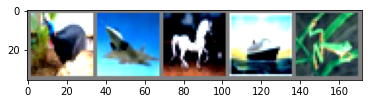

In [26]:
show_predicted_actual(model, device, testloader, classes)

In [27]:
evaluate_accuracy(model, device, testloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 80 %


In [28]:
evaluate_classwise_accuracy(model, device, classes, testloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of plane : 92 %
Accuracy of   car : 88 %
Accuracy of  bird : 68 %
Accuracy of   cat : 60 %
Accuracy of  deer : 82 %
Accuracy of   dog : 62 %
Accuracy of  frog : 73 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 80 %
